# Automatic Classification of Bright Retinal Lesions via Deep Network Features
**Original Paper Authors**
Ibrahim Sadeka,b,*, Mohamed Elawadyc,e, Abd El Rahman Shabayekd,e

### A reimplementation of the paper using python instead of matlab
Under supervision of Dr. Ibrahim Sadek, ibrahim.sadek@ipal.cnrs.fr

**Reimplementation Authors**
| **Name** | **Email** |
| --- | --- |
|[Mohamed Gaafer](github.com/mo-gaafar)| mohamed_gaafer@ieee.org|
|[Zeyad Mansour](github.com/ZeyadAlo) | zeyadmansour2@gmail.com |
|[Abdullah Saeed](github.com/abdullahsaeed10) ||
|[Maryam Moataz](github.com/maryamoataz) | maryam.fathy01@eng-st.cu.edu.eg|


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from PIL import Image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import normalize
from imblearn.over_sampling import SMOTE


# Code Structure
These are the main steps of the code:
1. Image Loading
2. Network Configuration
3. Data Preprocessing
4. CNN Feature Extraction using GoogleNet
5. Load pretrained SVM Model and Predict based on CNN Features


## 1. Image Loading

In [69]:
import ipywidgets as widgets
import os

directory = ""

# Function to display image files in a directory
def display_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')): 
                file_list.append(os.path.join(root, file))
    file_widget.options = file_list

# Define the directory widget
directory_widget = widgets.Text(value='../input', description='Directory:')
display(directory_widget)

# Define the file selection widget
file_widget = widgets.Dropdown(options=[], description='Files:')
display(file_widget)

# Define the callback function for directory changes
def directory_changed(change):
    directory = change['new']
    display_files(directory)
    print(directory)

# Link the directory widget to the callback function
directory_widget.observe(directory_changed, names='value')

# Initialize the file list
display_files(directory_widget.value)


Text(value='../input', description='Directory:')

Dropdown(description='Files:', options=(), value=None)

In [70]:
print("directory")
print(file_widget.value)

im = Image.open(file_widget.value)

directory
../input\Drusen\CJF_2009-02-09_OD_88358.jpg


## 2. Network Configuration

In [71]:
#googlenet
#inceptionV3

# resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
model_googlenet = ResNet50(weights='imagenet'
                        , include_top=False
                        , input_shape=(224, 224, 3)
                        , classes=1000)





#vgg16
# from tensorflow.keras.applications.preprocessing import preprocess_input
# model_googlenet = keras.applications.VGG16(weights='imagenet'
#                                           , include_top=False
#                                           , input_shape=(224, 224, 3)
#                                           , classes=1000)


#select and display the layer from ipywidget dropdown
layers_list = [layer.name for layer in model_googlenet.layers]
layer_widget = widgets.Dropdown(options=layers_list, description='Layers:')
display(layer_widget)


Dropdown(description='Layers:', options=('input_7', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool…

In [77]:
model = Model(inputs=model_googlenet.input, outputs=model_googlenet.get_layer(layer_widget.value).output)
# model_googlenet.summary()


## 3. Data Preprocessing

In [78]:
# Data Pre-processing
import os
import numpy as np
from PIL import Image

from preprocessing import process_images

# Define the input and output folder paths
input_folder = "../input"
output_folder = "../preprocessed_input"

classes = ["Drusen", "Normal", "Exudates"]

if os.path.exists(output_folder):
    os.system("rm -rf " + output_folder)
os.mkdir(output_folder)

for class_name in classes:
    os.mkdir(os.path.join(output_folder, class_name))
    process_images(os.path.join(input_folder, class_name), os.path.join(output_folder, class_name))



## 4. CNN Feature Extraction using GoogleNet

Found 95 images belonging to 3 classes.
95/95 [==============================] - 8s 72ms/step


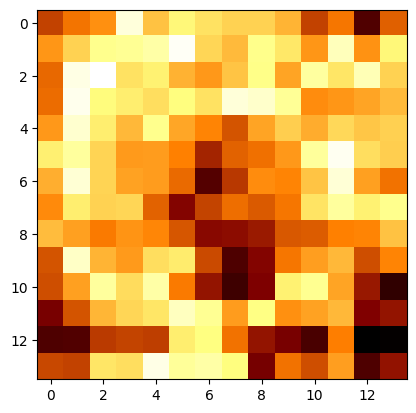

In [79]:
# CNN Feature Extraction using GoogleLeNet Model
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
image_data = data_generator.flow_from_directory(directory='../input', target_size=(224, 224), batch_size=1, shuffle=False)


labels = image_data.classes
features = model.predict(image_data)
plt.imshow(features[0,:,:,0],cmap = 'afmhot')


In [80]:
print(image_data.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## 5. SVM Prediction using CNN Features

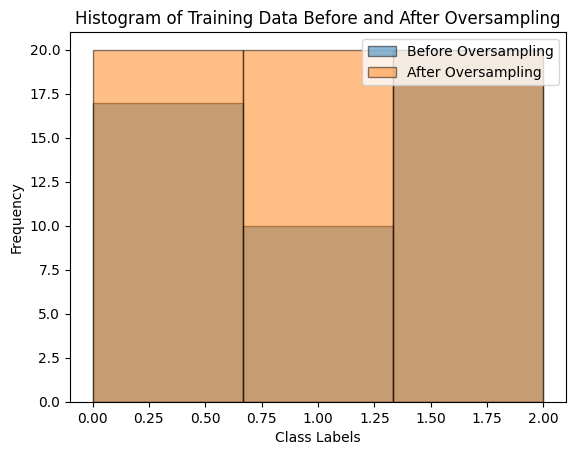

[1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 0, 0, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 0, 1, 2]
[1 0 0 1 0 1 0 0 2 0 2 0 2 0 2 1 2 1 0 1 0 2 2 2 0 2 0 0 1 2 2 2 2 0 0 2 1
 1 2 1 2 2 0 2 2 0 1 2]
[[17  0  0]
 [ 0 11  0]
 [ 0  1 19]]


In [114]:
# flatten the features
flattened_features = features.reshape(features.shape[0], -1)

# Split the data into training and testing sets with stratification
features_train, features_test, labels_train, labels_test \
= train_test_split(flattened_features, 
                    labels, 
                    test_size=0.5, 
                    stratify=labels)

# Imbalanced learning algorithm to create balanced training data
smote = SMOTE(random_state=1254)
features_oversampled , labels_oversampled = smote.fit_resample(features_train, 
                                                            labels_train)


# Plot histogram of training data before oversampling
# Synthetic Minority Oversampling Technique (SMOTE)
plt.hist(labels_train, bins=3, ec='black', alpha=0.5, label='Before Oversampling')

# Plot histogram of training data after oversampling
plt.hist(labels_oversampled, bins=3, ec='black', alpha=0.5, label='After Oversampling')

plt.title("Histogram of Training Data Before and After Oversampling")
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()



# Train an SVM classifier on the oversampled training data
cl = SVC(kernel='rbf', C=1.0, probability=True)
cl.fit(features_oversampled, labels_oversampled)


class_names = ['Drusen', 'Exudate', 'Normal', ...] 
predicted_class_name=[]
# Classify the image using the SVM classifier
for i in range(0, len(features_test)):
    predicted_label = cl.predict(features_test)[i]
    predicted_class_name.append(predicted_label)

# Output the classification result   
print(predicted_class_name)   
print(labels_test)

cm = confusion_matrix(labels_test, predicted_class_name)
print(cm)



## 6. Evaluation
Criteria used for evaluation:
- Sensitivity, specificity, accuracy, F-score, the area
under the curve
- Robustness
- Methodology
- Computational time

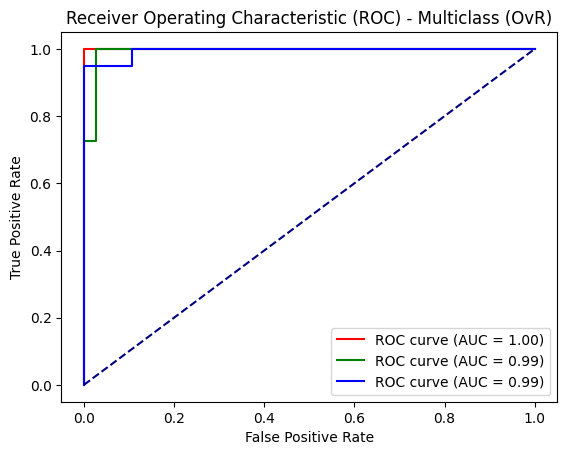

In [111]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Step 3: Convert the labels to binary form for ROC curve plotting
y_scores = cl.predict_proba(features_test)
n_classes = len(cl.classes_)
y_test_bin = label_binarize(labels_test, classes=cl.classes_)

# Step 4: Compute the ROC curve and AUC for each class (using OvR strategy)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 5: Plot the ROC curve for each class
plt.figure()
colors = ['red', 'green', 'blue']  # Customize the colors as needed
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve (AUC = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass (OvR)')
plt.legend(loc='lower right')
plt.show()

Sensitivity: 0.98
Specificity for class Drusen: 1.00
Specificity for class Exudate: 0.97
Specificity for class Normal: 0.97
Accuracy: 0.98
F-score: 0.98
AUC: 1.00


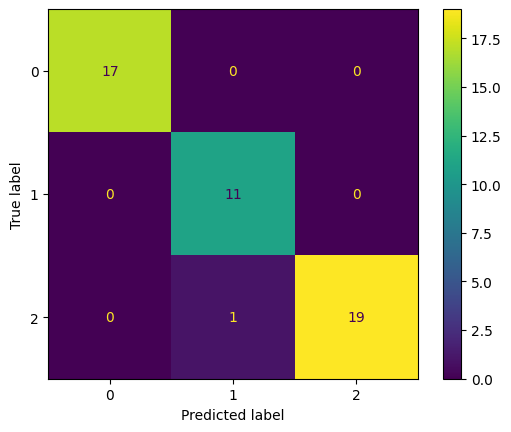

In [115]:

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

# Calculate the sensitivity
sensitivity = recall_score(labels_test, predicted_class_name, average='macro')

# Extract the true negatives (TN) and false positives (FP) for each class
tn_0 = np.sum(cm[1:, 1:])  # TN for class 0
fp_0 = np.sum(cm[1:, 0])   # FP for class 0
tn_1 = np.sum(np.vstack((cm[0, 0], cm[2, 2])))  # TN for class 1
fp_1 = np.sum(np.hstack((cm[0, 1:], cm[2, :2])))  # FP for class 1
tn_2 = np.sum(cm[:2, :2])  # TN for class 2
fp_2 = np.sum(np.hstack((cm[:2, 2], cm[2, 0:2])))  # FP for class 2

# Calculate the specificity for each class
spec_0 = tn_0 / (tn_0 + fp_0)
spec_1 = tn_1 / (tn_1 + fp_1)
spec_2 = tn_2 / (tn_2 + fp_2)

# Calculate the accuracy score
accuracy = accuracy_score(labels_test, predicted_class_name)

# Calculate the F-score
f_score = f1_score(labels_test, predicted_class_name, average='weighted')

# Calculate the AUC score
y_test = np.reshape(labels_test, (-1, 1))
y_pred = np.reshape(predicted_class_name, (-1, 1))
y_pred = normalize(y_pred, axis=1, norm='l1')
y_test = normalize(y_test, axis=1, norm='l1')

auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')

print("Sensitivity: {:.2f}".format(sensitivity))

print("Specificity for class Drusen: {:.2f}".format(spec_0))
print("Specificity for class Exudate: {:.2f}".format(spec_1))
print("Specificity for class Normal: {:.2f}".format(spec_2))

print("Accuracy: {:.2f}".format(accuracy))

print("F-score: {:.2f}".format(f_score))

print("AUC: {:.2f}".format(auc_score))

# show the confusion matrix plot
plt.show()